In [1]:
#Install
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas
!pip install python-dotenv
!pip install requests_cache matplotlib pandas retry_requests openmeteo_requests

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
#Import Dependencies
import openmeteo_requests
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import requests_cache
import pandas as pd
from retry_requests import retry

In [3]:
#Setup the Open-Meteo API Client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

In [4]:
# Define locations
locations = {
    "Tulsa": (36.154, -95.9928),
    "Los Angeles": (34.0522, -118.2437),
    "New York": (40.7128, -74.0060)
}

In [5]:
# Dictionary to store DataFrames for each location
location_data = {}

In [6]:
# Fetch and process data for each location
for city, (lat, lon) in locations.items():
    responses = openmeteo.weather_api(
        url="https://archive-api.open-meteo.com/v1/archive",
        params={
            "latitude": lat,
            "longitude": lon,
            "start_date": "2014-01-01",
            "end_date": "2023-12-31",
            "daily": ["temperature_2m_max", "temperature_2m_min", "precipitation_sum"],
            "temperature_unit": "fahrenheit",
            "precipitation_unit": "inch",
            "timezone": "America/Chicago"
        }
    )

    # Assuming responses is a list, loop through it
    for response in responses:
        if hasattr(response, 'Daily'):  # Check if 'Daily' exists
            daily = response.Daily()  # Call the function to get the daily data
            
            # Debugging: Print the retrieved daily data structure
            print(f"Daily data structure for {city}: {daily}")

            daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
            daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
            daily_precipitation_sum = daily.Variables(2).ValuesAsNumpy()

            # Assume Time and Interval are methods or attributes of daily data
            daily_time = daily.Time()  # No arguments needed if this retrieves the time array
            daily_interval = daily.Interval()  # Assume this retrieves the interval

            daily_data = {
                "date": pd.date_range(
                    start=pd.to_datetime(daily_time, unit="s", utc=True),
                    periods=len(daily_temperature_2m_max),  # Use the length of the data arrays
                    freq=pd.Timedelta(seconds=daily_interval)
                ),
                "temperature_2m_max": daily_temperature_2m_max,
                "temperature_2m_min": daily_temperature_2m_min,
                "precipitation_sum": daily_precipitation_sum
            }

            # Convert to DataFrame and store in dictionary
            location_data[city] = pd.DataFrame(data=daily_data)
            break  # Exit loop once the daily data is found

Daily data structure for Tulsa: <openmeteo_sdk.VariablesWithTime.VariablesWithTime object at 0x000001C7A2AC98D0>
Daily data structure for Los Angeles: <openmeteo_sdk.VariablesWithTime.VariablesWithTime object at 0x000001C7A2ACBFA0>
Daily data structure for New York: <openmeteo_sdk.VariablesWithTime.VariablesWithTime object at 0x000001C7A2AC93C0>


In [7]:
# Load the CSV files
tulsa_aqi_data = pd.read_csv(r'C:\Users\jasmi\Projects\Project_1\Project-1-Elysium\Tulsa_AQI_data.csv')
la_aqi_data = pd.read_csv(r'C:\Users\jasmi\Projects\Project_1\Project-1-Elysium\LA_AQI_data.csv')
ny_aqi_data = pd.read_csv(r'C:\Users\jasmi\Projects\Project_1\Project-1-Elysium\NY_AQI_data.csv')

In [8]:
# return merged_data
def prepare_data(aqi_data):
    # Use 'arithmetic_mean' as the AQI measurement
    aqi_filtered = aqi_data[['Year', 'quarter', 'arithmetic_mean']]
    
    # Create a complete DataFrame with all combinations of years and quarters
    years = range(2014, 2024)
    quarters = [1, 2, 3, 4]
    complete_index = pd.MultiIndex.from_product([years, quarters], names=['Year', 'quarter'])
    complete_df = pd.DataFrame(index=complete_index).reset_index()
    
    # Group by Year and Quarter, then calculate the mean AQI for each group
    grouped_data = aqi_filtered.groupby(['Year', 'quarter']).mean().reset_index()
    
    # Merge the complete DataFrame with the grouped data to ensure all combinations are present
    merged_data = pd.merge(complete_df, grouped_data, on=['Year', 'quarter'], how='left')
    
    # Fill missing values using interpolation
    merged_data['arithmetic_mean'] = merged_data['arithmetic_mean'].interpolate()
    
    # Create a new column for plotting that combines year and quarter
    merged_data['Year_Quarter'] = merged_data['Year'] + (merged_data['quarter'] - 1) / 4
    
    return merged_data

In [9]:
# Prepare the data for each city
tulsa_data = prepare_data(tulsa_aqi_data)
la_data = prepare_data(la_aqi_data)
ny_data = prepare_data(ny_aqi_data)

In [10]:
# Map city names to their respective AQI data
aqi_data = {
    "Tulsa": tulsa_data,
    "Los Angeles": la_data,
    "New York": ny_data}

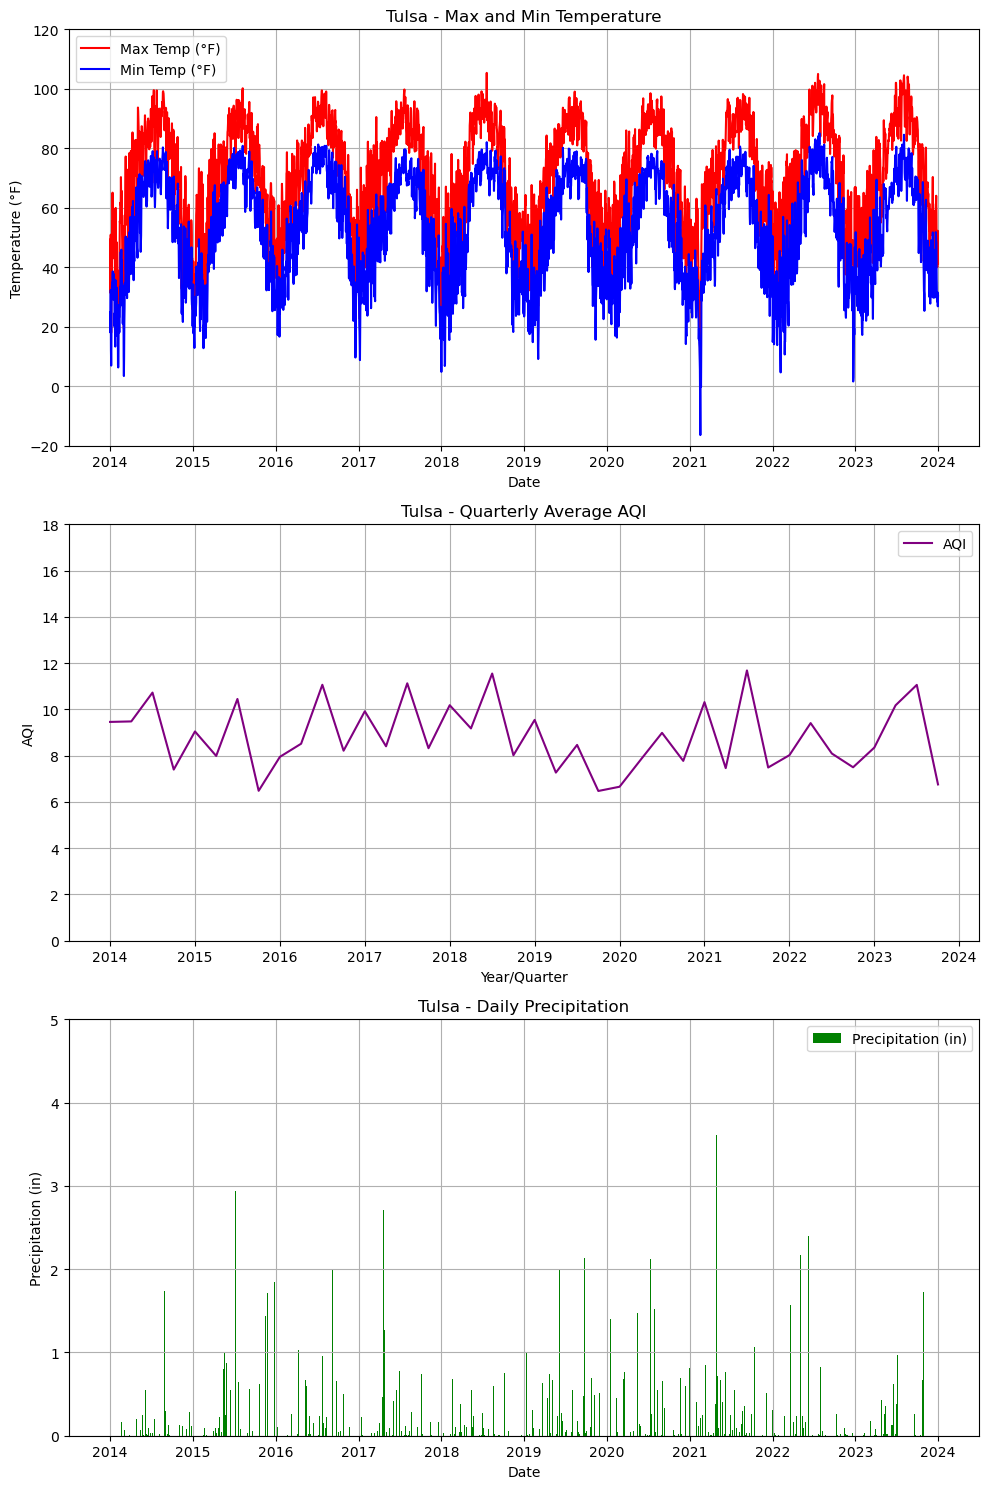

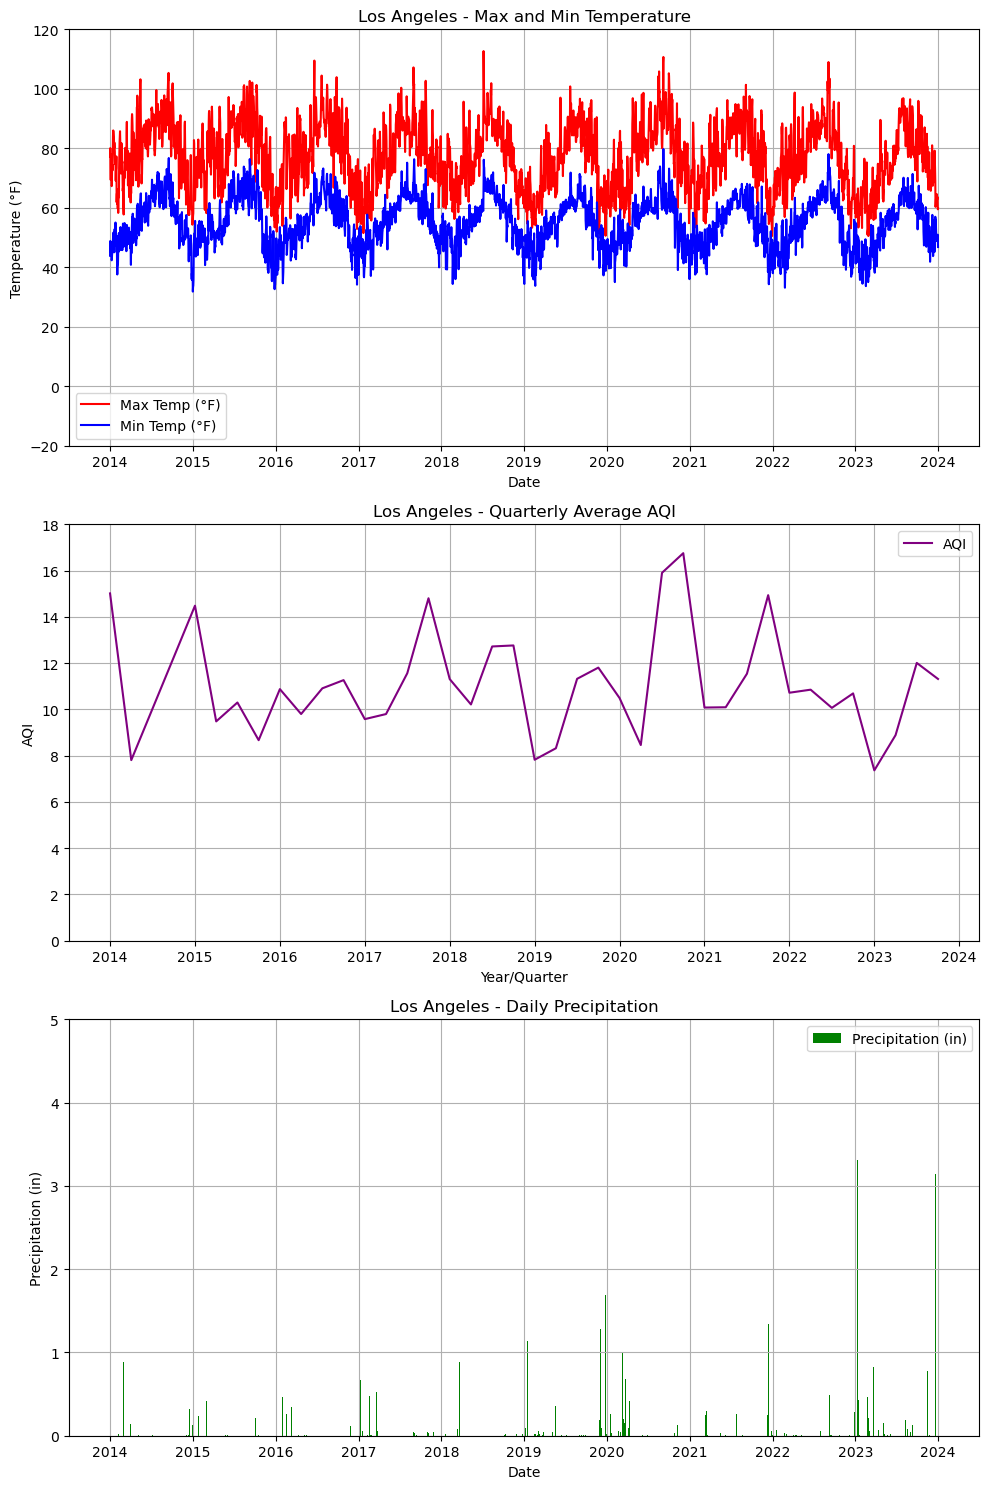

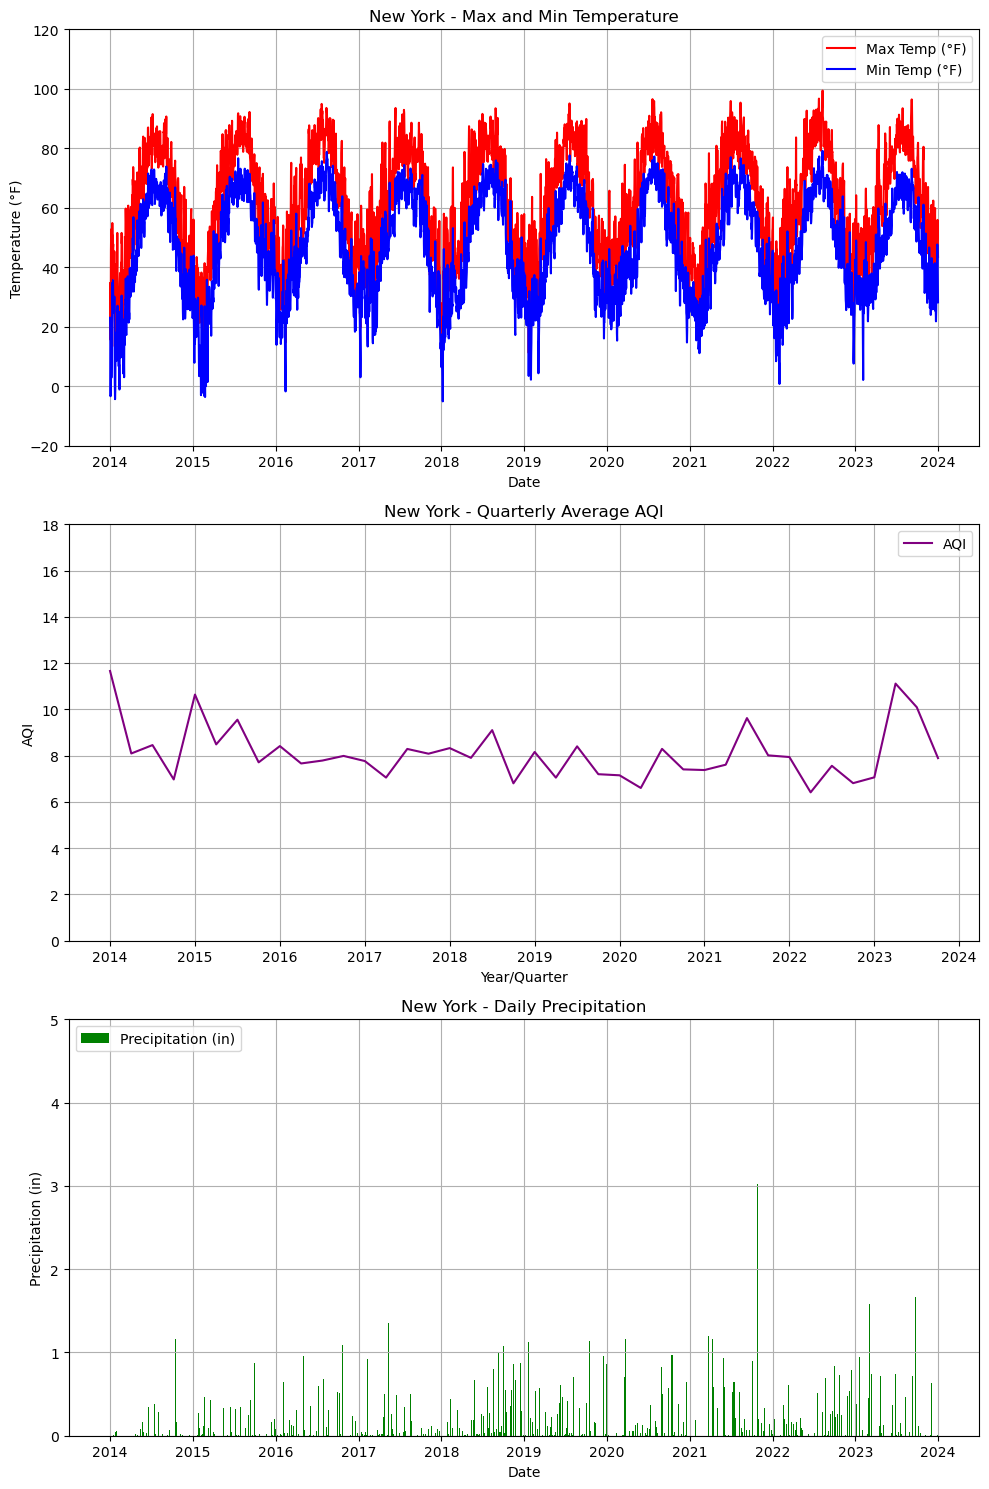

In [11]:
# Create tri graphs
for city in locations.keys():
    fig, axes = plt.subplots(3, 1, figsize=(10, 15))

    # Temperature plot
    df_temp = location_data[city]
    axes[0].plot(df_temp['date'], df_temp['temperature_2m_max'], label='Max Temp (°F)', color='red')
    axes[0].plot(df_temp['date'], df_temp['temperature_2m_min'], label='Min Temp (°F)', color='blue')
    axes[0].set_title(f"{city} - Max and Min Temperature")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("Temperature (°F)")
    axes[0].set_ylim(-20, 120)  # uniform temperature
    axes[0].legend()
    axes[0].grid(True)

    
    # AQI plot 1
    df_aqi = aqi_data[city]
   
   
    axes[1].plot(df_aqi['Year_Quarter'], df_aqi['arithmetic_mean'], label='AQI', color='purple')
    axes[1].set_title(f"{city} - Quarterly Average AQI")
    axes[1].set_xlabel("Year/Quarter")
    axes[1].set_ylabel("AQI")
    axes[1].set_ylim(0, 18)  # uniform AQI limits
    axes[1].xaxis.set_major_locator(mtick.MultipleLocator(1))
    axes[1].legend()
    axes[1].grid(True)  

    

      # Precipitation plot
    axes[2].bar(df_temp['date'], df_temp['precipitation_sum'], label='Precipitation (in)', color='green', alpha=1)
    axes[2].set_title(f"{city} - Daily Precipitation")
    axes[2].set_xlabel("Date")
    axes[2].set_ylabel("Precipitation (in)")
    axes[2].set_ylim(0, 5)  # uniform inches
    axes[2].legend()
    axes[2].grid(True)
    
  
    plt.tight_layout()
   
    plt.savefig(f"{city}_3Gs.png", format='png')
    plt.show()